# ANOVA

Exploging a 1-way ANOVA model, looking at the plant growth dataset

## Using Sklearn

### Import Data

In [1]:
# Download the data from here: 
# https://vincentarelbundock.github.io/Rdatasets/datasets.html

URL = 'https://vincentarelbundock.github.io/Rdatasets/csv/datasets/PlantGrowth.csv'
import urllib.request
import numpy as onp
import seaborn as sns
from sklearn import preprocessing

In [2]:
response = urllib.request.urlopen(URL)

In [3]:
d = onp.genfromtxt(
    onp.DataSource(None).open(URL),
    skip_header=1,
    delimiter=',',
    usecols=(1, 2),
    converters={2: lambda x: x.strip('""')},
    dtype='f8, U32',
    encoding=None
)
_Y, _X = zip(*d)
Y = np.array(_Y)
X_cat = np.array(_X)

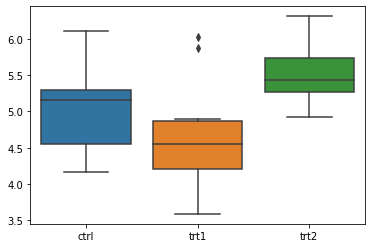

In [4]:
sns.boxplot(x=X_cat, y=Y)

### Fit a linear model

We fit a linear model of the form

$$
y = \mathbb{1}_{\rm trt1}\cdot x_1 + \mathbb{1}_{\rm trt2}\cdot x_2 + x_3
$$

with $x_1$ being data for group `trt1`, $x_2$ being data for group `trt2`, and $x_3$ being data for group `ctrl`

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression

In [6]:
_X = preprocessing.LabelEncoder().fit_transform(X_cat)
X = preprocessing.OneHotEncoder(categories='auto').fit_transform(_X.reshape(-1, 1)).toarray()
X[:, 0] = 1  # Set ctrl to 'intercept'

In [7]:
# y = is_tr1*tr1 + is_tr2*tr2 + ctrl
lmod = LinearRegression().fit(X, Y.reshape(-1, 1))

In [8]:
print(lmod.intercept_, lmod.coef_)

[5.032] [[ 0.    -0.371  0.494]]


## Using StatsModel

https://www.statsmodels.org/stable/index.html

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Import Data

In [10]:
df = sm.datasets.get_rdataset('PlantGrowth').data

/Users/benhammel/Documents/projects/bayesian-stats-classes/venv/lib/python3.6/site-packages/statsmodels/datasets/utils.py:192: FutureWarning: `item` has been deprecated and will be removed in a future version
  return dataset_meta["Title"].item()


In [11]:
df.head()

,weight,group
0,4.17,ctrl
1,5.58,ctrl
2,5.18,ctrl
3,6.11,ctrl
4,4.50,ctrl


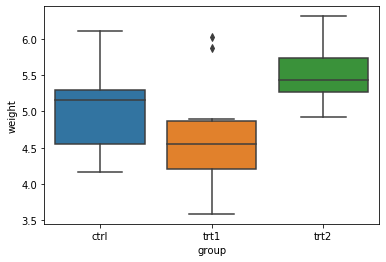

In [12]:
sns.boxplot(x='group', y='weight', data=df)

### Fit a linear model

In [13]:
lmod = smf.ols('weight ~ group', data=df).fit()

In [14]:
lmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 weight   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     4.846
Date:                Mon, 11 Nov 2019   Prob (F-statistic):             0.0159
Time:                        08:30:37   Log-Likelihood:                -26.810
No. Observations:                  30   AIC:                             59.62
Df Residuals:                      27   BIC:                             63.82
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.0320      0.197     25.527      0.000       4.628       5.436
group[T.trt1]    -0.3710      0.279     -1.331      0.194      -0.943       0.201
group[T.trt2]     0.4940      0.279      1.772      0.088      -0.078       1.066
==============================================================================
Omnibus:                        1.835   Durbin-Watson:                   2.704
Prob(Omnibus):                  0.400   Jarque-Bera (JB):                1.406
Skew:                           0.524   Prob(JB):                        0.495
Kurtosis:                       2.835   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
table = sm.stats.anova_lm(lmod)
print(table)

            df    sum_sq   mean_sq         F   PR(>F)
group      2.0   3.76634  1.883170  4.846088  0.01591
Residual  27.0  10.49209  0.388596       NaN      NaN


## Bayesian Model

In [16]:
from jax import random
import jax.numpy as np  # We need the CUDA mirror of numpy (even if we're on a CPU)

import numpyro
import numpyro.diagnostics as diag
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

numpyro.set_host_device_count(3)  # Run mcmc in parallel
numpyro.enable_validation()  # Let pyro alert me to potential problems

In [17]:
def model_fn(X, weight):
    
    # We need mu to have shape (3,) to corespond to ctrl, trt1, trt2
    mu = numpyro.sample('mu', dist.Normal(np.zeros(3), 1e6).to_event(1))
    var = numpyro.sample('var', dist.InverseGamma(2.5, 5*.5))
    std = np.sqrt(var)
    
    # X an indecator matrix
    # So if we do a dot product with the plant weights we'll select the features of interest
    y = X @ mu
    
    numpyro.sample('y', dist.Normal(loc=y, scale=std), obs=weight)

    
def model_fn_alt(X, weight):
    """I Believe this is the more "correct "
    """
    
    # We need mu to have shape (3,) to corespond to ctrl, trt1, trt2
    # We have batch data. So we specify that the batch demention is "independent" for one-another
    # e.g. that the feature demention is a single measurment "event"
    mu = numpyro.sample('mu', dist.Normal(np.zeros(3), 1e6).to_event(1))
    var = numpyro.sample('var', dist.InverseGamma(2.5, 5*.5))
    std = np.sqrt(var)
    
    y = X @ mu  # numpy dot product short hand. X an indecator matrix. 
    
    with numpyro.plate('y_plate', len(X)):
        numpyro.sample('y', dist.Normal(loc=y, scale=std), obs=weight)

In [18]:
num_warmup, num_samples = 1000, 5000
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [19]:
kernel = NUTS(model_fn)
model = MCMC(kernel, num_warmup, num_samples, num_chains=3)
model.run(rng_key, collect_warmup=False, X=X, weight=Y)

In [20]:
samples = model.get_samples()
mod_mu = samples['mu'].reshape(3, -1, 3)

In [21]:
diag.gelman_rubin(mod_mu[..., 0])

0.9999592

In [22]:
diag.gelman_rubin(mod_mu[..., 1])

1.0001432

In [23]:
diag.gelman_rubin(mod_mu[..., 2])

0.99997705

In [24]:
lag_idx = [0, 1, 5, 10, 50]

In [25]:
diag.autocorrelation(mod_mu[...,0], axis=1)[:, lag_idx]

array([[ 1.        ,  0.38502714,  0.04157489, -0.0118481 ,  0.04964556],
       [ 1.        ,  0.38907949,  0.0534757 ,  0.02518965,  0.00391679],
       [ 1.        ,  0.34820563,  0.0100994 , -0.01741638, -0.03695177]])

In [26]:
diag.autocorrelation(mod_mu[...,1], axis=1)[:, lag_idx]

array([[ 1.        ,  0.32681395,  0.04119776, -0.00672299,  0.06459818],
       [ 1.        ,  0.30854863,  0.02218104,  0.02363467, -0.01052499],
       [ 1.        ,  0.2890658 , -0.00554207,  0.00655359, -0.04137163]])

In [27]:
diag.autocorrelation(mod_mu[...,2], axis=1)[:, lag_idx]

array([[ 1.        ,  0.33108124,  0.03220302, -0.00484913,  0.00381925],
       [ 1.        ,  0.34054588,  0.03346048,  0.01854997, -0.02191796],
       [ 1.        ,  0.28725971,  0.00368886,  0.00144189, -0.00349336]])

In [28]:
diag.effective_sample_size(onp.array(mod_mu[...,0]))

5758.660210434228

In [29]:
diag.effective_sample_size(onp.array(mod_mu[...,1]))

6384.403213350743

In [30]:
diag.effective_sample_size(onp.array(mod_mu[...,2]))

6116.981257389004

The above numbers are greater than 5000, the length of a single chain. Not sure how to interpret that...

## Residules

In [31]:
w = mod_mu.reshape(-1, 3)

In [32]:
y_hat = X @ w.T
y_hat_mean = y_hat.mean(axis=1)

In [33]:
residules = Y - y_hat_mean

Text(0, 0.5, 'residule')

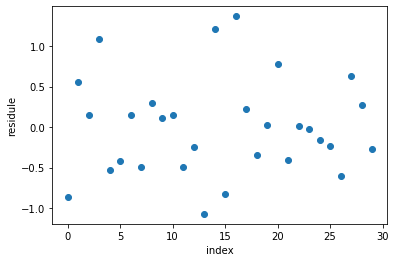

In [34]:
plt.plot(residules, 'o')
plt.xlabel('index')
plt.ylabel('residule')

Text(0, 0.5, 'residule')

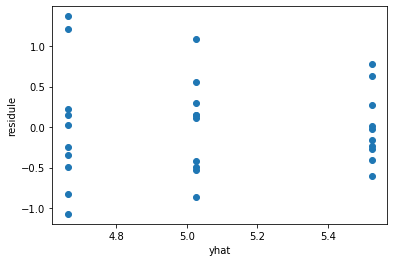

In [35]:
plt.plot(y_hat_mean, residules, 'o')
plt.xlabel('yhat')
plt.ylabel('residule')

### Model summary

In [36]:
model.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     mu[0]      5.03      0.23      5.03      4.66      5.40   5758.68      1.00
     mu[1]     -0.37      0.32     -0.37     -0.89      0.16   6384.40      1.00
     mu[2]      0.50      0.32      0.50     -0.03      1.02   6116.98      1.00
       var      0.52      0.14      0.49      0.30      0.72   8925.43      1.00

Number of divergences: 0


Because we used the intercept term, then mu for `trt1` needs to be `mu[0] + mu[1]` for our results to match the tutorial

In [58]:
crt_mu = onp.array(w)  # copy our weight matrix
crt_mu[..., 1] += crt_mu[..., 0]
crt_mu[..., 2] += crt_mu[..., 0]

### Highest posterior density interval

In [44]:
onp.unique(diag.hpdi(y_hat, prob=.99, axis=1), axis=0)

array([[4.0598803, 5.2498355],
       [4.433491 , 5.636921 ],
       [4.9203434, 6.114285 ]], dtype=float32)

In [45]:
onp.unique(diag.hpdi(y_hat, prob=.90, axis=1), axis=0)

array([[4.306698 , 5.0441027],
       [4.656371 , 5.3992414],
       [5.149457 , 5.893162 ]], dtype=float32)

### Does treatmet 2 increase yeild?

In [59]:
onp.mean(crt_mu[..., 2] > crt_mu[..., 0])

0.9412

What is the probability that the yeild is increased by at least 10%

In [60]:
onp.mean(crt_mu[..., 2] > 1.1 * crt_mu[..., 0])

0.49546666666666667